## **Forecasting PM2.5 Value**

**PM2.5 is an air pollutant that is a concern for people's health when levels in air are high**

Attribute Information:

1. No: row number
2. year: year of data in this row
3. month: month of data in this row
4. day: day of data in this row
5. hour: hour of data in this row
6. pm2.5: PM2.5 concentration (ug/m^3)
7. DEWP: Dew Point
8. TEMP: Temperature
9. PRES: Pressure (hPa)
10. cbwd: Combined wind direction
11. Iws: Cumulated wind speed (m/s)
12. Is: Cumulated hours of snow
13. Ir: Cumulated hours of rain


### **Load Library**

In [1]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import tensorflow as tf

### **Load Data**

In [2]:
data = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv")
data.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


### **Dropping data with NaN value of PM2.5**

In [3]:
data = data.dropna()
data.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
24,25,2010,1,2,0,129.0,-16,-4.0,1020.0,SE,1.79,0,0
25,26,2010,1,2,1,148.0,-15,-4.0,1020.0,SE,2.68,0,0
26,27,2010,1,2,2,159.0,-11,-5.0,1021.0,SE,3.57,0,0
27,28,2010,1,2,3,181.0,-7,-5.0,1022.0,SE,5.36,1,0
28,29,2010,1,2,4,138.0,-7,-5.0,1022.0,SE,6.25,2,0


### **Dropping time attributes and categorical attributes**

In [4]:
data_train = data.drop(['No', 'year', 'month', 'day', 'hour', 'cbwd'], axis=1)
data_train.reset_index().drop(['index'], axis=1).head(20)

,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir
0,129.0,-16,-4.0,1020.0,1.79,0,0
1,148.0,-15,-4.0,1020.0,2.68,0,0
2,159.0,-11,-5.0,1021.0,3.57,0,0
3,181.0,-7,-5.0,1022.0,5.36,1,0
4,138.0,-7,-5.0,1022.0,6.25,2,0
5,109.0,-7,-6.0,1022.0,7.14,3,0
6,105.0,-7,-6.0,1023.0,8.93,4,0
7,124.0,-7,-5.0,1024.0,10.72,0,0
8,120.0,-8,-6.0,1024.0,12.51,0,0
9,132.0,-7,-5.0,1025.0,14.30,0,0


### **Checking null value for every attributes**

In [5]:
data_train.isnull().sum() 

pm2.5    0
DEWP     0
TEMP     0
PRES     0
Iws      0
Is       0
Ir       0
dtype: int64

In [6]:
data_train.describe()

,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir
count,41757.000000,41757.000000,41757.000000,41757.000000,41757.000000,41757.000000,41757.000000
mean,98.613215,1.750174,12.401561,1016.442896,23.866747,0.055344,0.194866
std,92.050387,14.433658,12.175215,10.300733,49.617495,0.778875,1.418165
min,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000
25%,29.000000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000
50%,72.000000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000
75%,137.000000,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000
max,994.000000,28.000000,42.000000,1046.000000,565.490000,27.000000,36.000000


### **Making data transformation function**

In [7]:
def data2sequences(data, window_size=1):
  X = []
  y = []
  scaler = MinMaxScaler(feature_range=(0,1))
  scaled = scaler.fit_transform(data)
  for i in range(len(data)-window_size):
    X.append(scaled[i:i+window_size])
    y.append(data['pm2.5'].iloc[i+window_size])
  
  return X, y, scaler


### **Transform data into sequential data attributes with 10 consecutive days as input features**

In [8]:
X, y, scaler = data2sequences(data_train, window_size=10)

### **Dividing data into train and test**

In [9]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), test_size=0.2, shuffle=False)

### **Designing model for prediction**

In [10]:
model = tf.keras.models.Sequential([                                  
  tf.keras.layers.LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])),
  tf.keras.layers.Dense(256),
  tf.keras.layers.Dense(256),
  tf.keras.layers.Dense(1, activation='linear')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

model.compile(loss='mae',
              optimizer=optimizer,
              metrics=["mae"])

callbacks = [tf.keras.callbacks.EarlyStopping(patience=10,
                                              monitor='val_loss',
                                              restore_best_weights=True)]
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               43200     
                                                                 
 dense (Dense)               (None, 256)               25856     
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 135,105
Trainable params: 135,105
Non-trainable params: 0
_________________________________________________________________


### **Training the model**

In [11]:
history = model.fit(X_train.astype('float32'),
                    y_train.astype('float32'), epochs=100,
                    batch_size=64,
                    validation_data=(X_test.astype('float32'),
                                     y_test.astype('float32')),
                    callbacks=callbacks)

Epoch 1/100
522/522 [==============================] - 7s 9ms/step - loss: 21.1082 - mae: 21.1082 - val_loss: 12.0092 - val_mae: 12.0092
Epoch 2/100
522/522 [==============================] - 4s 8ms/step - loss: 13.7585 - mae: 13.7585 - val_loss: 11.6799 - val_mae: 11.6799
Epoch 3/100
522/522 [==============================] - 4s 8ms/step - loss: 14.1248 - mae: 14.1248 - val_loss: 11.5846 - val_mae: 11.5846
Epoch 4/100
522/522 [==============================] - 4s 8ms/step - loss: 13.7703 - mae: 13.7703 - val_loss: 12.3273 - val_mae: 12.3273
Epoch 5/100
522/522 [==============================] - 4s 8ms/step - loss: 13.4783 - mae: 13.4783 - val_loss: 11.9097 - val_mae: 11.9097
Epoch 6/100
522/522 [==============================] - 4s 8ms/step - loss: 13.8016 - mae: 13.8016 - val_loss: 12.3741 - val_mae: 12.3741
Epoch 7/100
522/522 [==============================] - 4s 8ms/step - loss: 13.5034 - mae: 13.5034 - val_loss: 11.3335 - val_mae: 11.3335
Epoch 8/100
522/522 [====================

### **Plotting the train and validation metrics**

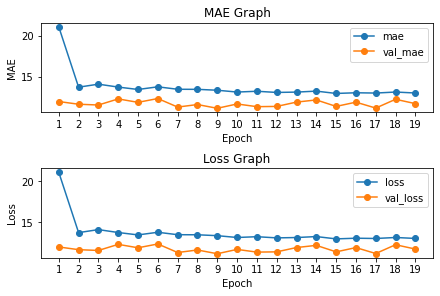

In [12]:
import matplotlib.pyplot as plt
import matplotlib as mpl


fig, ax = plt.subplots(2, constrained_layout=True)

ax[0].xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
ax[1].xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))

x = np.arange(1, len(history.history['mae'])+1)

ax[0].plot(x, history.history['mae'], label='mae', marker='o')
ax[0].plot(x, history.history['val_mae'], label='val_mae', marker='o')
ax[0].set_xticks(x)
ax[0].legend()
ax[0].set_title('MAE Graph')
ax[0].set_ylabel('MAE')
ax[0].set_xlabel('Epoch')

ax[1].plot(x, history.history['loss'], label='loss', marker='o')
ax[1].plot(x, history.history['val_loss'], label='val_loss', marker='o')
ax[1].set_xticks(x)
ax[1].legend()
ax[1].set_title('Loss Graph')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')

plt.show()

In [15]:
max = data_train.describe()['pm2.5']['max']
min = data_train.describe()['pm2.5']['min']

prediction = model.predict(X_train)
prediction2 = model.predict(X_test)

print('MAE Train Data : ', mean_absolute_error(y_train, prediction))
print('MAE Test Data : ', mean_absolute_error(y_test, prediction2))

MAE Train Data :  12.598840874858462
MAE Test Data :  11.185407124971915


### **Plotting Actual and Prediction Value of PM2.5** 

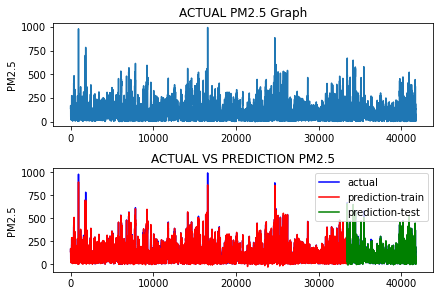

In [14]:
fig, ax2 = plt.subplots(2, constrained_layout=True)

ax2[0].plot(y)
ax2[0].set_title('ACTUAL PM2.5 Graph')
ax2[0].set_ylabel('PM2.5')

ax2[1].plot(y, color='blue', label='actual')
ax2[1].plot(range(0, len(y_train)), prediction, color='red', label='prediction-train')
ax2[1].plot(range(len(y_train),len(y)), prediction2, color='green', label='prediction-test')
ax2[1].set_title('ACTUAL VS PREDICTION PM2.5')
ax2[1].set_ylabel('PM2.5')
plt.legend()

plt.show()